### XGBoost Model

In [29]:
import pandas as pd, numpy as np, gc
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import random
import matplotlib.pyplot as plt

### Load Preprocessed Features

In [5]:
df = pd.read_csv('../data/feature_merged/features_train_all.csv', index_col=0)
df

,fraction_of_common_click,level_group,fullscreen,hq,music,elapsed_time_over10000_ratio,elapsed_time_over20000_ratio,elapsed_time_over50000_ratio,elapsed_time_over100000_ratio,elapsed_time_over200000_ratio,...,hover_duration_std,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0.865385,0-4,0.0,0.0,1.0,0.012121,0.012121,0.000000,0.000000,0.000000,...,3227.370757,81,22,28,11,4,8,2,4,1
20090312433251036,0.861538,0-4,0.0,0.0,0.0,0.014388,0.014388,0.000000,0.000000,0.000000,...,2114.876406,49,18,36,15,3,5,3,2,1
20090312455206810,0.737931,0-4,1.0,1.0,1.0,0.020134,0.013423,0.006711,0.006711,0.006711,...,4575.148668,57,18,49,10,2,9,2,0,1
20090313091715820,0.755952,0-4,1.0,1.0,1.0,0.011364,0.011364,0.000000,0.000000,0.000000,...,1949.073577,80,22,34,18,2,8,2,2,1
20090314035813970,0.653061,0-4,0.0,0.0,1.0,0.032468,0.012987,0.006494,0.000000,0.000000,...,5603.987571,53,24,31,12,1,9,2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22090619362224080,0.831094,13-22,0.0,0.0,1.0,0.019678,0.003578,0.001789,0.001789,0.001789,...,3085.040477,234,123,54,38,20,9,15,4,1
22100212552203824,0.891700,13-22,0.0,0.0,1.0,0.009560,0.002868,0.000956,0.000956,0.000956,...,2683.530185,649,135,61,41,28,17,20,5,1
22100213081672770,0.816635,13-22,0.0,0.0,1.0,0.001742,0.001742,0.001742,0.001742,0.001742,...,1194.839127,240,129,79,40,20,14,6,5,1


### Load Labels

In [8]:
targets = pd.read_csv('../data/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


### Train XGBoost Model

In [6]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 75 features
We will train with 18849 users info


In [21]:
group = df.index
total_set = group.nunique()
train_set_size = int(0.8 * total_set)
random.seed(42)
train_index = random.sample(list(group), train_set_size)
train_set = df[df.index.isin(train_index)]
val_set = df[~df.index.isin(train_index)]

val_pred = pd.DataFrame(data=np.zeros((val_set.index.nunique(),18)), index=val_set.index.unique())
models = {}

xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
#     'learning_rate': 0.05,
#     'max_depth': 4,
#     'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 2000],
    'max_depth': [3, 4, 5]}   # Adjust hyperparameter

# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1, 19):
    print('#'*25)
    print('### Question',t)
    print('#'*25)

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: grp = '0-4'
    elif t<=13: grp = '5-12'
    elif t<=22: grp = '13-22'

    # TRAIN DATA
    train_x = train_set.loc[train_set.level_group == grp]
    train_users = train_x.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # VALID DATA
    valid_x = val_set.loc[val_set.level_group == grp]
    valid_users = valid_x.index.values
    valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    grid_search = GridSearchCV(clf, param_grid, scoring='roc_auc', cv=5)
    grid_search.fit(train_x[FEATURES].astype('float32'), train_y['correct'],\
                    eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],\
                    verbose=0, groups=train_x.index)
    best_clf = grid_search.best_estimator_
    best_learning_rate = grid_search.best_params_['learning_rate']
    best_n_estimators = grid_search.best_params_['n_estimators']
    best_max_depth = grid_search.best_params_['max_depth']

    # print(f'{t}({best_clf.best_ntree_limit}), ',end='')
    print(best_learning_rate, best_n_estimators, best_max_depth)

    # SAVE MODEL, PREDICT VALID val_pred
    models[f'{grp}_{t}'] = best_clf
    val_pred.loc[valid_users, t-1] = best_clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]

#########################
### Question 1
#########################
0.01 1000 4
#########################
### Question 2
#########################
0.01 1000 3
#########################
### Question 3
#########################
0.01 500 4
#########################
### Question 4
#########################
0.01 1000 4
#########################
### Question 5
#########################
0.01 1000 4
#########################
### Question 6
#########################
0.01 1000 3
#########################
### Question 7
#########################
0.01 1000 4
#########################
### Question 8
#########################
0.01 500 3
#########################
### Question 9
#########################
0.01 1000 3
#########################
### Question 10
#########################
0.01 1000 3
#########################
### Question 11
#########################
0.01 1000 3
#########################
### Question 12
#########################
0.01 1000 3
#########################
### Question 13
#########

In [22]:
val_pred

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090314363702160,0.869715,0.993116,0.980102,0.948084,0.882700,0.958656,0.933039,0.781175,0.933340,0.820563,0.830302,0.950111,0.386947,0.702357,0.588243,0.730861,0.730477,0.976368
20090314441803444,0.942066,0.994597,0.983772,0.892393,0.606591,0.847324,0.836854,0.712570,0.786025,0.490697,0.650121,0.888686,0.261808,0.835292,0.655409,0.761539,0.773434,0.989939
20090315101457836,0.849530,0.993457,0.963661,0.853540,0.524322,0.789725,0.722544,0.579933,0.726254,0.454316,0.660084,0.874425,0.226664,0.730301,0.552505,0.742217,0.702023,0.983116
20090317111400710,0.677127,0.967381,0.880895,0.582668,0.247733,0.465313,0.436748,0.548371,0.591337,0.331048,0.469749,0.824695,0.123028,0.665330,0.351960,0.692319,0.611130,0.951864
20090317414400068,0.590693,0.992317,0.917690,0.881184,0.548714,0.818368,0.768292,0.588487,0.737679,0.403114,0.644420,0.895252,0.216043,0.780464,0.392714,0.734484,0.700782,0.970754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22100215032067016,0.792450,0.982240,0.952216,0.910922,0.721019,0.928648,0.922600,0.705028,0.835839,0.723088,0.848341,0.930278,0.318830,0.824970,0.508621,0.748716,0.751287,0.992933
22100215342220508,0.569000,0.985628,0.923809,0.911554,0.509423,0.844611,0.824379,0.594580,0.795489,0.482720,0.675862,0.913024,0.242291,0.745045,0.583325,0.720089,0.561418,0.976554
22100215460321130,0.590478,0.982008,0.879959,0.853933,0.558520,0.824222,0.675504,0.553709,0.779921,0.493350,0.636286,0.881674,0.186300,0.701035,0.539981,0.739203,0.645906,0.974177


### Check feature importance based on XGBoost

In [87]:
important_features = []
unimportant_features = []

for clf in models.values():
    importance = clf.feature_importances_
    feature_importance = pd.Series(importance, index=FEATURES).to_dict()
    feature_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=True))
    feature_least_importance = dict(sorted(feature_importance.items(), key=lambda item: item[1], reverse=False))
    feature_top10 = list(feature_importance.keys())[:10]
    feature_bottom10 = list(feature_least_importance.keys())[:10]
    important_features.append(feature_top10)
    unimportant_features.append(feature_bottom10)

In [88]:
flattened_list = [item for sublist in important_features for item in sublist]
flattened_list1 = [item for sublist in unimportant_features for item in sublist]

In [89]:
temp = list(range(1, 11)) * 18

In [91]:
df_importance = pd.DataFrame({
    'FEATURE': flattened_list,
    'Scores(1-importance)': temp
})
df_least_importance = pd.DataFrame({
    'FEATURE': flattened_list1,
    'Scores(1-least importance)': temp
})

In [92]:
most_importance = df_importance.groupby(by='FEATURE')['Scores(1-importance)'].mean().sort_values(ascending=True).reset_index().head(10)
least_importance = df_least_importance.groupby(by='FEATURE')['Scores(1-least importance)'].mean().sort_values(ascending=True).reset_index().head(10)

In [95]:
least_importance['Scores(1-least importance)'] = round(least_importance['Scores(1-least importance)'], 1)

In [96]:
least_importance

,FEATURE,Scores(1-least importance)
0,hq,1.0
1,level_swapping_ratio,1.4
2,bingo_time_mean,1.7
3,elapsed_time_over500000_ratio,2.0
4,tunic.capitol_0.hall_room_elapsed_time,2.6
5,first_bingo_elapsed_time,2.7
6,tunic.capitol_2.hall_room_elapsed_time,2.7
7,tunic.capitol_1.hall_room_elapsed_time,3.7
8,tunic.flaghouse.entry_room_elapsed_time,3.9
9,tunic.historicalsociety.closet_room_elapsed_time,4.6


### Compute CV Score

In [23]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = val_pred.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[val_set.index.unique()]
    true[k] = tmp.correct.values

In [28]:
true.values.reshape((-1))

array([1, 1, 1, ..., 0, 1, 1])

In [24]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (val_pred.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

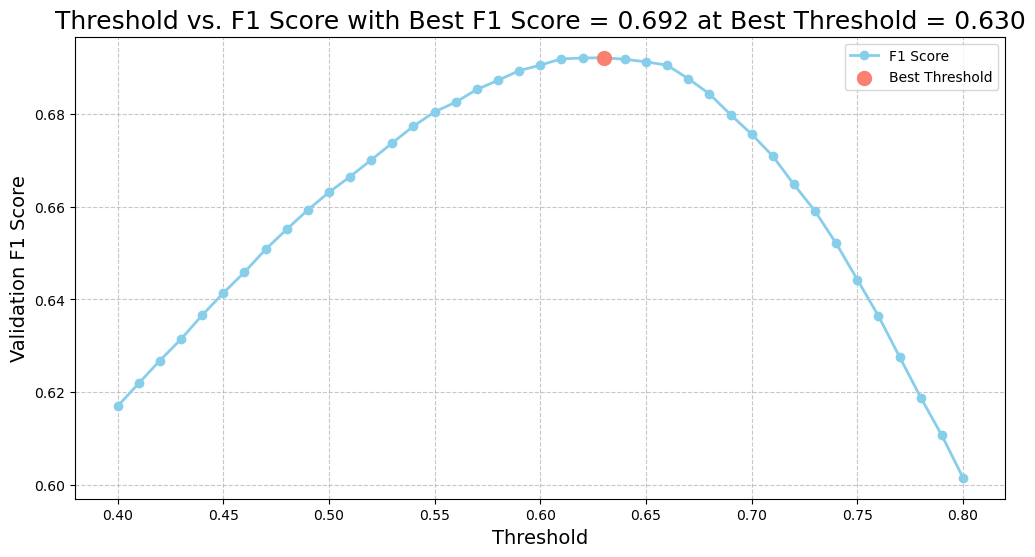

In [67]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, scores, '-o', color='skyblue', label='F1 Score', linewidth=2, markersize=6)

# Highlighting the best threshold and score
plt.scatter([best_threshold], [best_score], color='salmon', s=100, label='Best Threshold', zorder=5)

# Adding labels and title
plt.xlabel('Threshold', size=14)
plt.ylabel('Validation F1 Score', size=14)
plt.title(f'Threshold vs. F1 Score with Best F1 Score = {best_score:.3f} at Best Threshold = {best_threshold:.3f}', size=18)

# Adding a legend
plt.legend()

# Adding grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Displaying the plot
plt.show()


### Infer Test Data (Already feature engineered)

In [61]:
test_set = pd.read_csv('../data/feature_merged/features_test_all.csv', index_col=0)
test_preds = pd.DataFrame(data=np.zeros((test_set.index.nunique(),18)), index=test_set.index.unique())
f1_dfs = []

for t in range(1, 19):

    if t<=3: grp = '0-4'
    elif t<=13: grp = '5-12'
    elif t<=22: grp = '13-22'

    # TEST DATA
    test_x = test_set.loc[test_set.level_group == grp]
    test_users = test_x.index.values
    test_y = targets.loc[targets.q==t].set_index('session').loc[test_users]

    clf = models[f'{grp}_{t}']
    test_pred = clf.predict_proba(test_x[FEATURES].astype('float32'))[:,1]
    test_preds.loc[test_users, t-1] = test_pred

    tmp = targets.loc[targets.q == t].set_index('session').loc[test_set.index.unique()]
    true = tmp.correct.values

    test_outcome = (test_pred>best_threshold).astype('int')
    f1 = f1_score(true, test_outcome, average='macro') 
    f1_dfs.append({
        'Question': f'Question{t}',
        'F1 Score': f1
    })

In [68]:
f1_df = pd.DataFrame(f1_dfs)
f1_df.to_csv('f1_df.csv')

In [100]:
test_preds

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
session_id,,,,,,,,,,,,,,,,,,
20090313571836404,0.937566,0.994226,0.981910,0.929459,0.856561,0.955478,0.900823,0.777749,0.926571,0.762394,0.814757,0.958191,0.506152,0.807215,0.541928,0.765333,0.771913,0.991111
20090315085850788,0.793098,0.992181,0.943048,0.932882,0.652395,0.867857,0.775642,0.632667,0.793296,0.554701,0.688923,0.887059,0.256265,0.794535,0.545229,0.724181,0.633206,0.974982
20090315170769824,0.828427,0.990608,0.964524,0.942524,0.824957,0.959968,0.921037,0.708403,0.924319,0.777331,0.884901,0.950989,0.333327,0.823448,0.626342,0.752990,0.737273,0.988536
20090316152177500,0.562354,0.988073,0.920219,0.911769,0.589924,0.811524,0.731423,0.569855,0.763023,0.491129,0.600824,0.903553,0.185780,0.555181,0.260377,0.695028,0.554348,0.933445
20090317080721164,0.410532,0.973486,0.870382,0.594499,0.256764,0.540869,0.640906,0.475983,0.528144,0.160479,0.537254,0.837976,0.093153,0.734942,0.531682,0.726177,0.646401,0.982014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22090618050629904,0.672631,0.992617,0.969625,0.913672,0.566456,0.805232,0.770941,0.661771,0.796506,0.560635,0.698393,0.900836,0.367554,0.697412,0.508504,0.719990,0.614464,0.912895
22100208551963804,0.716023,0.980984,0.959747,0.805812,0.450595,0.702899,0.698278,0.567736,0.758519,0.592253,0.708272,0.855494,0.200794,0.787818,0.655107,0.748585,0.707271,0.958921
22100209282577744,0.948720,0.994940,0.981323,0.929969,0.777940,0.951262,0.904160,0.716314,0.887320,0.774924,0.822792,0.951017,0.368772,0.746111,0.561328,0.726488,0.666467,0.956869


In [60]:
# Total F1 Score
test_true = test_preds.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[test_set.index.unique()]
    test_true[k] = tmp.correct.values

test_outcomes = (test_preds.values.reshape((-1))>best_threshold).astype('int')
f1 = f1_score(test_true.values.reshape((-1)), test_outcomes, average='macro') 
print(f'Total F1 Score: {f1}')

Total F1 Score: 0.6931744862369612
